In [1]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.explain import Explainer, PGExplainer, AttentionExplainer, GNNExplainer
from cell_dataset import load

from genericpath import exists

from cell_model import Gatv2Predictor

import torch

In [2]:
load_all =  True #load directly from a pickle
pre_separated = False #if three subfolders already exist for train test and val

override = False #make this true to always use the same ones

extension = "_open_ht_hv"
number_of_messages = 2
size_of_messages = 64
absolute = 0
epochs = 80

model_path = "models/model" + extension + "_" + str(number_of_messages) + "_" + str(size_of_messages) + "_" + ("absolute" if absolute else "relative")
loss_path = "models/loss" + extension + "_" + str(number_of_messages) + "_" + str(size_of_messages) + "_" + ("absolute" if absolute else "relative")

data_train, data_test, data_val = load(load_all, extension, pre_separated, override)

Validation data not found


In [3]:
load = True

epoch_to_load = 79

model = Gatv2Predictor(in_channels=12, out_channels=8, hidden_channels=size_of_messages, dropout=0.05, edge_dim=2, messages=number_of_messages, wrap=data_train.wrap, absolute=absolute)

if exists(model_path + str(epoch_to_load) + ".pt") and load :
    model.load_state_dict(torch.load(model_path + str(epoch_to_load) + ".pt"))
    print("Loaded model")

In [4]:
"""
explainer = Explainer(
    model=model,
    algorithm=PGExplainer(epochs=20, lr=0.003),
    explanation_type='phenomenon',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    ),
    # Include only the top 10 most important edges:
    #threshold_config=dict(threshold_type='topk', value=10),
)



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
explainer.algorithm = explainer.algorithm.to(device)

# PGExplainer needs to be trained separately since it is a parametric
# explainer i.e it uses a neural network to generate explanations:
for epoch in range(20):
    for i in range(data_test.len()):
        x, edge_index, edge_attr, border, params = data_test.get(i)
        
        edge_index = edge_index.to(device)
        edge_attr = edge_attr.to(device)
        params = params.to(device)
        x = x.to(device)
        
        xshape = x.shape
        
        start = 1
        end = xshape[0] - 1
        
        mask = torch.logical_and(torch.div(edge_index[0, :], xshape[1], rounding_mode='floor') >= start, \
                            torch.div(edge_index[0, :], xshape[1], rounding_mode='floor') < end)
    
        edge_index = (edge_index[:, mask] - xshape[1])
        
        kwargs= {"x" : x[start:end], "edge_index":edge_index, "edge_attr": edge_attr[mask], "params":params}
    
        target = x[start+1:end+1,:, :model.out_channels // 2]
        
        loss = explainer.algorithm.train(
            epoch, model, kwargs["x"], kwargs["edge_index"], target=target, edge_attr=kwargs["edge_attr"], params=kwargs["params"], only_mean=True)
        
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}', end='\r')
        
x, edge_index, edge_attr, border, params = data_test.get(0)

xshape = x.shape

edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)
params = params.to(device)
x = x.to(device)

start = 1
end = xshape[0] - 1

mask = torch.logical_and(torch.div(edge_index[0, :], xshape[1], rounding_mode='floor') >= start, \
                    torch.div(edge_index[0, :], xshape[1], rounding_mode='floor') < end)

edge_index = (edge_index[:, mask] - xshape[1])

kwargs= {"x" : x[start:end], "edge_index":edge_index, "edge_attr": edge_attr[mask], "params":params}

target = x[start+1:end+1,:, :model.out_channels // 2]
# Generate the explanation for a particular graph:
explanation = explainer(x=kwargs["x"], edge_index=kwargs["edge_index"], target=target, edge_attr=kwargs["edge_attr"], params=kwargs["params"])
print(explanation.edge_mask)
"""

'\nexplainer = Explainer(\n    model=model,\n    algorithm=PGExplainer(epochs=20, lr=0.003),\n    explanation_type=\'phenomenon\',\n    edge_mask_type=\'object\',\n    model_config=dict(\n        mode=\'regression\',\n        task_level=\'graph\',\n        return_type=\'raw\',\n    ),\n    # Include only the top 10 most important edges:\n    #threshold_config=dict(threshold_type=\'topk\', value=10),\n)\n\n\n\ndevice = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')\nmodel = model.to(device)\nexplainer.algorithm = explainer.algorithm.to(device)\n\n# PGExplainer needs to be trained separately since it is a parametric\n# explainer i.e it uses a neural network to generate explanations:\nfor epoch in range(20):\n    for i in range(data_test.len()):\n        x, edge_index, edge_attr, border, params = data_test.get(i)\n        \n        edge_index = edge_index.to(device)\n        edge_attr = edge_attr.to(device)\n        params = params.to(device)\n        x = x.to(device)\n 

In [5]:
explainer = Explainer(
    model=model,
    algorithm=AttentionExplainer(),
    explanation_type='model',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='edge',
        return_type='raw',
    ),
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
explainer.algorithm = explainer.algorithm.to(device)

x, edge_index, edge_attr, border, params = data_test.get(0)

xshape = x.shape

edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)
params = params.to(device)
x = x.to(device)

start = 1
end = 2#xshape[0] - 1

mask = torch.logical_and(torch.div(edge_index[0, :], xshape[1], rounding_mode='floor') >= start, \
                    torch.div(edge_index[0, :], xshape[1], rounding_mode='floor') < end)

edge_index = (edge_index[:, mask] - xshape[1])

kwargs= {"x" : x[start:end][0], "edge_index":edge_index, "edge_attr": edge_attr[mask], "params":params}

print(kwargs["x"].shape, kwargs["edge_index"].shape, kwargs["edge_attr"].shape, kwargs["params"].shape)

target = x[start+1:end+1,:, :model.out_channels // 2]
# Generate the explanation for a particular graph:
explanation = explainer(x=kwargs["x"], edge_index=kwargs["edge_index"], target=target, edge_attr=kwargs["edge_attr"], params=kwargs["params"])

torch.Size([100, 5]) torch.Size([2, 1000]) torch.Size([1000, 2]) torch.Size([7])


c:\Users\gille\miniconda3\envs\geom\lib\site-packages\torch_geometric\explain\explainer.py:189: UserWarning: The 'target' should not be provided for the explanation type 'model'
  warnings.warn(


In [14]:
print(kwargs["x"].shape, kwargs["edge_index"].shape, kwargs["edge_attr"].shape, kwargs["params"].shape)

torch.Size([1, 100, 5]) torch.Size([2, 1000]) torch.Size([1000, 2]) torch.Size([7])


In [7]:
print(explanation.edge_mask.sum())

tensor(224.1970, device='cuda:0')


In [8]:
explanation.validate()

True

In [9]:
print(kwargs["x"].shape)

torch.Size([1, 100, 5])


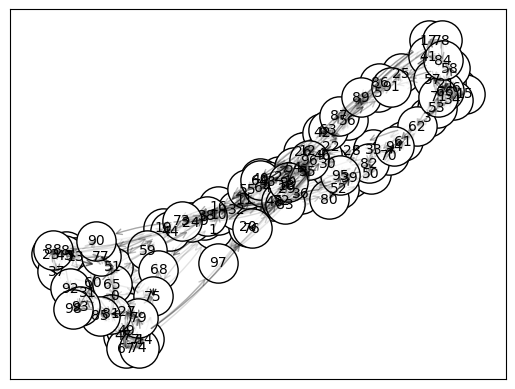

In [10]:
#edge_masks = explanation.edge_mask
#edge_masks[edge_masks < 0.35] = 0
#explanation.edge_mask = edge_masks
explanation.visualize_graph()

In [11]:
exp = explanation.get_explanation_subgraph()

In [12]:
print(exp)

Explanation(edge_mask=[1000], prediction=[1, 100, 8], target=[1, 100, 8], x=[100, 5], edge_index=[2, 1000], edge_attr=[1000, 2], params=[7])


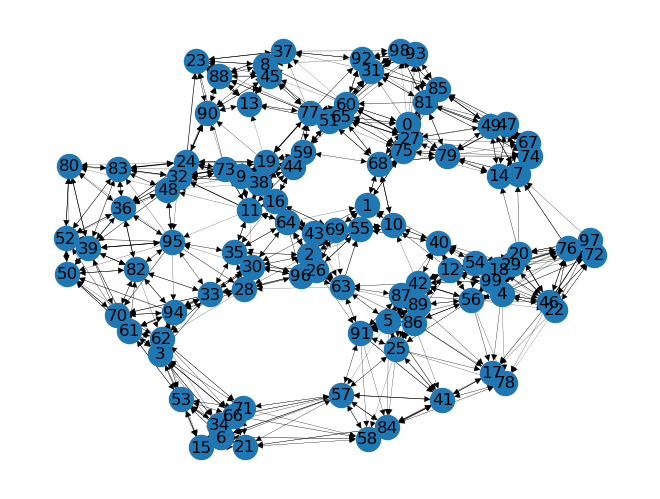

In [13]:
import networkx as nx
import torch_geometric
import matplotlib.pyplot as plt
import numpy as np

g = torch_geometric.utils.to_networkx(exp, to_undirected=False, remove_self_loops=True)

#draw the edges with the edge mask as the width
widths = explanation.edge_mask.cpu().numpy()
pos = exp.x[:,:2].cpu().numpy()

nx.draw(g, pos, with_labels=True, width=widths)
